## UpSet Plot: Condition Co-Occurrence

This section builds an **UpSet plot** to show how often different clinical conditions  
occur together in the same patients. It is a scalable alternative to Venn diagrams  
and helps us see co-morbidity patterns and frequent condition combinations.


In [1]:
"""
UpSet Plot — Condition Co-Occurrence Visualizer
------------------------------------------------
This script finds the most common clinical conditions and shows how often 
they appear together in patient records. The UpSet plot helps us see which 
conditions tend to co-occur, and the strength of those intersections.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)



### Step 1 — Load Data and Identify Key Columns

We first load the dataset and automatically detect which columns represent  
the **patient ID** and which represent the **clinical condition**.  
We then drop incomplete rows and clean condition labels so later intersections  
are based on consistent, valid values.


In [2]:
# Load Data & Identify Key Columns

df = pd.read_csv("final_with_deceased.csv")

# Identify the patient ID column
id_candidates = [c for c in df.columns if "id" in c.lower() or "person" in c.lower()]
condition_candidates = [c for c in df.columns if "condition" in c.lower()]

PATIENT_COL = id_candidates[0] if id_candidates else "person_id"
CONDITION_COL = condition_candidates[0] if condition_candidates else "condition"

# Keep only rows that contain both patient ID and condition
df = df.dropna(subset=[PATIENT_COL, CONDITION_COL])
df[CONDITION_COL] = df[CONDITION_COL].astype(str).str.strip()

### Step 2 — Focus on the Most Frequent Conditions

To keep the visualization readable, we restrict the analysis to the **top 8 most  
frequent conditions** and limit combinations to size 1–3. This focuses the plot  
on the most clinically relevant and common patterns.


In [3]:
#  Select Top-N Most Common Conditions

TOP_N = 8       # analyze only the most frequent 8 conditions
MAX_SET_SIZE = 3    # size of combinations to evaluate (pairs or triples)

top_conditions = df[CONDITION_COL].value_counts().head(TOP_N).index



### Step 3 — Build Condition Sets per Patient

Here we convert row-level data into **patient-level condition sets**.  
Each patient is represented by the set of top conditions they have,  
which is required for computing intersections between conditions.


In [4]:
# Create a list of conditions per patient
patient_to_conditions = (
    df[df[CONDITION_COL].isin(top_conditions)]
    .groupby(PATIENT_COL)[CONDITION_COL]
    .apply(set)
)

### Step 4 — Count Condition Intersections

For each patient’s condition set, we enumerate all valid combinations  
(single conditions, pairs, and triples) and count how many patients share  
each combination. These counts will drive the bar heights in the plot.


In [5]:
# Compute Intersection Frequencies

# Count how many times each combination appears
combo_counter = Counter()

for condition_set in patient_to_conditions:
    condition_list = list(condition_set)
    for size in range(1, min(len(condition_list), MAX_SET_SIZE) + 1):
        for combo in itertools.combinations(sorted(condition_list), size):
            combo_counter[combo] += 1




### Step 5 — Keep the Strongest Intersections

We sort all combinations by frequency and keep the **top 25 intersections**.  
This avoids clutter and ensures the UpSet plot highlights the most  
informative and frequent co-occurrence patterns.


In [6]:
# Keep only the top 25 highest-frequency intersections
ranked_intersections = sorted(
    combo_counter.items(), 
    key=lambda x: (-x[1], len(x[0]))
)[:25]

# Convert results to DataFrame
plot_data = pd.DataFrame([
    {"combo": combo, "count": count}
    for combo, count in ranked_intersections
])

### Step 6 — Create the UpSet Membership Matrix

We now build a **binary matrix** where rows are conditions and columns  
are intersections. A value of `1` means the condition belongs to that  
intersection. This matrix directly controls the dot grid of the UpSet plot.


In [7]:
# Build Binary Matrix for the UpSet Structure

conditions = list(top_conditions)
num_conditions = len(conditions)
num_intersections = len(plot_data)

# rows = conditions, columns = intersections
binary_matrix = np.zeros((num_conditions, num_intersections), dtype=int)

for col_index, combo in enumerate(plot_data["combo"]):
    for condition in combo:
        row_index = conditions.index(condition)
        binary_matrix[row_index, col_index] = 1

### Step 7 — Define the UpSet Plot Layout

This function renders the UpSet plot using Matplotlib:

- A **top bar chart** shows how large each intersection is (number of patients).  
- A **dot matrix** below shows which conditions are active in each intersection,  
  with lines connecting conditions that co-occur in the same combination.


In [8]:
# UpSet Plot Rendering Function

def plot_upset(matrix, data, condition_labels):
    """
    Creates a simple UpSet-style visualization using:
    - A top bar chart showing sizes of intersections
    - A dot matrix showing which conditions participate in each intersection
    """
    rows, cols = matrix.shape

    fig = plt.figure(figsize=(max(10, cols * 0.45), 6))

    # --- Top Bar Chart ----------------------------------------------------
    bar_ax = fig.add_axes([0.15, 0.6, 0.8, 0.35])
    bar_color = "#CC0000"

    bar_ax.bar(range(cols), data["count"], color=bar_color, edgecolor="gray", linewidth=0.3)

    # Add labels above each bar
    for idx, value in enumerate(data["count"]):
        bar_ax.text(idx, value + value * 0.02, str(value),
                    ha="center", fontsize=9, color="#222")

    bar_ax.set_xticks([])
    bar_ax.set_ylabel("Intersection Size")
    bar_ax.set_title("Top Condition Intersections")
    bar_ax.grid(axis="y", linestyle="--", alpha=0.35)

    # --- Dot Matrix -------------------------------------------------------
    dot_ax = fig.add_axes([0.15, 0.15, 0.8, 0.4])
    
    # alternating background rows for readability
    for i in range(rows):
        dot_ax.axhspan(i - 0.5, i + 0.5, 
                       facecolor=("#f8f8f8" if i % 2 else "white"),
                       zorder=0)

    # plot dots for each intersection
    for col in range(cols):
        active_rows = np.where(matrix[:, col] == 1)[0]

        # light grey baseline dots
        dot_ax.scatter(
            [col] * rows, range(rows),
            color="#D3D3D3", s=28, zorder=1
        )

        # highlight active dots
        dot_ax.scatter(
            [col] * len(active_rows), active_rows,
            color=bar_color, s=60, zorder=3
        )

        # connect dots with a line if > 1 condition participates
        if len(active_rows) > 1:
            dot_ax.plot(
                [col] * len(active_rows), active_rows,
                color=bar_color, linewidth=2, zorder=2
            )

    # formatting
    dot_ax.set_yticks(range(rows))
    dot_ax.set_yticklabels(condition_labels, fontsize=10)
    dot_ax.invert_yaxis()
    dot_ax.set_xticks(range(cols))
    dot_ax.set_xticklabels(range(1, cols + 1), fontsize=9)
    dot_ax.set_xlabel("Intersection Index (ranked)")
    dot_ax.grid(axis="y", linestyle=":", alpha=0.25)

    plt.show()

### Step 8 — Render the Final UpSet Plot

Finally, we pass the membership matrix, intersection counts, and condition  
labels into `plot_upset`. This produces the UpSet plot that summarizes  
which conditions occur together and how frequently.


Rendering UpSet Plot…


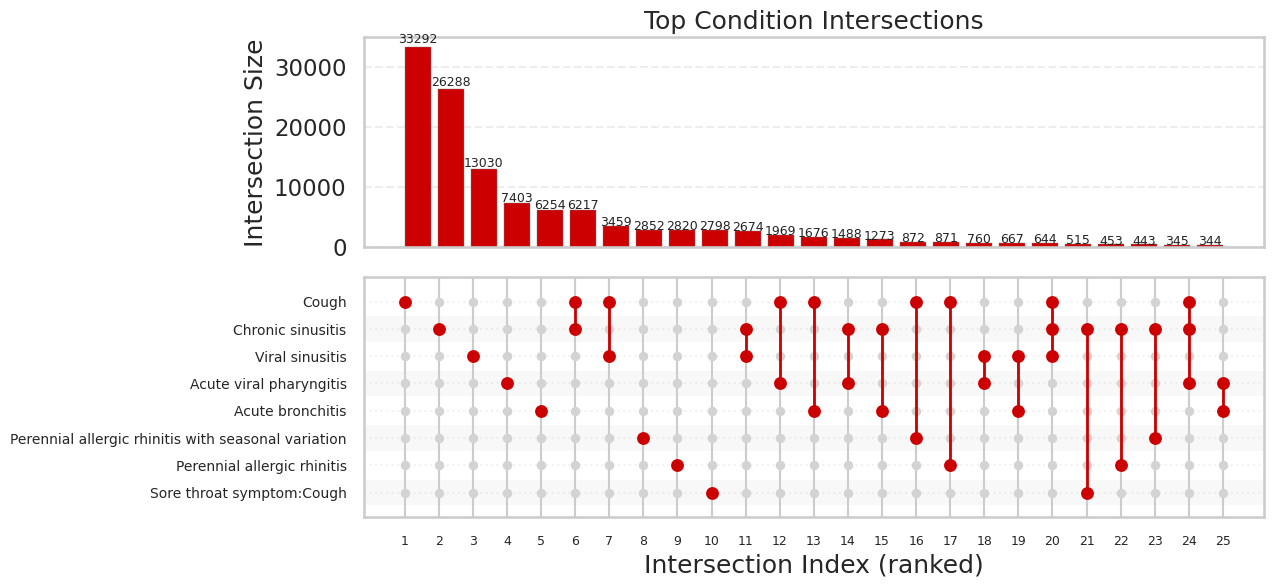

In [9]:
#  Render UpSet Plot

print("Rendering UpSet Plot…")
plot_upset(binary_matrix, plot_data, conditions)